## This tutorial covers XGBoost (classification) & Cross Validation

In [56]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, balanced_accuracy_score, roc_auc_score, make_scorer


### Missing Data: Identify

We have to make sure that the data is correctly formatted/not missing, and then label/drop the rows accordingly. 

One thing that's good about XGBoost, is that it has default behavior for handling missing data - it is expecting it. So all we have to do is to identify missing data, and set them to 0. 

You might think that setting it to 0, might cause clashes in data when it is also 0. However, XGBoost's algorithm handles this perfectly.

#### Problem: To predict if someone will stop using Telco's services, using both categorical and continuous datatypes.

In [117]:
#we are going to start with IBM's telco churn dataset. 
telco_df = pd.read_csv('Telco_customer_churn.csv')

telco_df


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,One year,Yes,Mailed check,84.80,1990.5,No,0,59,2140,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN


Based on the table's data, the last 4 columns are going to give us a "perfect prediction", because the data that was provided also includes people that already left the telco. 

So we are going to drop those 4 columns, so that our model will not be biased. 

This is an example of feature engineering/data manipulation in the real world. We trim/add data to solve specific problems.

In [118]:
telco_df.drop(columns=['Churn Label','Churn Score', 'CLTV','Churn Reason'],
              axis = 1, #axis = 1 tells the function to drop columns. axis = 0 drop rows.
              inplace=True)
telco_df

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.4,0
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,0
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,0
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0


We also see that there are a lot of redundant columns, that don't value add to our model. Drop them as well.

In [119]:
telco_df.drop(columns=['CustomerID','Count','Country','State','Lat Long'],axis=1,inplace=True)

In [60]:
telco_df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [120]:
telco_df['City'].replace(' ','_',regex=True, inplace=True)

In [121]:
telco_df.columns = telco_df.columns.str.replace(' ', '_')
telco_df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


YAY! We now identified and gotten rid of unvaluable information, and also cleaned up our dataset. 

In [122]:
telco_df['Phone_Service'].unique()
#prints out the number of unique items in the df

array(['Yes', 'No'], dtype=object)

In [123]:
pd.to_numeric(telco_df['Total_Charges'])

ValueError: Unable to parse string " " at position 2234

turns out we have missing data (" ")! lets fix that.

we need to change the missing data to "0". XGBoost is good at handling that.

In [124]:
telco_df.loc[(telco_df['Total_Charges'] == " "), "Total_Charges"] = 0

In [125]:
telco_df['Total_Charges'] = pd.to_numeric(telco_df['Total_Charges'])

YAY. total charges is now a float object, which is what XGBoost requires.

Now let's do it for all the other columns.

In [126]:
telco_df.replace(" ", "_", regex=True, inplace=True)


In [127]:
telco_df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

### Formatting our data for XGBoost

Our target is column "Churn_Value", and the rest are our features.

In [128]:
y = telco_df['Churn_Value'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

In [129]:
X = telco_df.drop("Churn_Value", axis =1).copy()

In [91]:
X

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Landers,92285,34.341737,-116.539416,Female,No,No,No,72,Yes,...,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,Yes,Bank_transfer_(automatic),21.15,1419.40
7039,Adelanto,92301,34.667815,-117.536183,Male,No,Yes,Yes,24,Yes,...,No,Yes,Yes,Yes,Yes,One_year,Yes,Mailed_check,84.80,1990.50
7040,Amboy,92304,34.559882,-115.637164,Female,No,Yes,Yes,72,Yes,...,Yes,Yes,No,Yes,Yes,One_year,Yes,Credit_card_(automatic),103.20,7362.90
7041,Angelus_Oaks,92305,34.167800,-116.864330,Female,No,Yes,Yes,11,No,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,29.60,346.45


Now to **one-hot encode** our data.

It basically turns our categorical data into binary form by adding more columns, and only allowing values "1" or "0" only.

`pd.get_dummies(X, columns=['Payment_Method']).head()` shows this really well

In [130]:
pd.get_dummies(X, columns=['Payment_Method']).head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,Yes,Month-to-month,Yes,99.65,820.50,0,0,1,0
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Month-to-month,Yes,104.80,3046.05,0,0,1,0
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,Month-to-month,Yes,103.70,5036.30,1,0,0,0


we're gonna do this for all the categorical data

note: in real world situations, part of a data scientist's job is to go through each of the data, and determine if its categorical or not. 

since we are using toy data, the work has already been done for us.

In [131]:
X_encoded = pd.get_dummies(X, columns=['City',
                                       'Gender', 'Senior_Citizen',
                                       'Partner', 'Dependents','Phone_Service',
                                       'Multiple_Lines','Internet_Service',
                                       'Online_Security','Online_Backup','Device_Protection',
                                       'Tech_Support','Streaming_TV','Streaming_Movies','Contract',
                                       'Paperless_Billing','Payment_Method'])

X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


Wow! 1178 Columns.
as this is a binary classification problem, let's verify that our column only has 1 and 0

In [132]:
y.unique()

array([1, 0], dtype=int64)

ok slay. Time to build the model!

We notice that our dataset is imbalanced - the number of people who left are is significantly lesser. 

In our `train_test_split()` function, we need to call `stratify=y`, so that our split can have equal amount of classes. (Affects our accuracy)

In [133]:
sum(y)/len(y)
#~27% of our data represents people who left. we need the same for train & test 

0.2653698707936959

In [134]:
X_encoded.fillna(0,inplace=True)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y)

In [136]:
sum(y_train)/len(y_train)

0.2653532126375577

ok model time!

when we're building the trees, at some point, the model will NOT improve. XGBoost is going to build `early_stopping_rounds=10` more trees. If those 10 trees, none of them can improve on the prediction, then it'll stop.

We are using `eval_metric='aucpr'` to interprete how well the predictions are. `eval_set` evaluates how many trees to build


In [137]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic', #normal classification method
                              missing=0, #tell xgboost which character we are using to label as an empty value
                              use_label_encoder=False,seed=42) 
model_xgb.fit(X_train, y_train,
              verbose=True, # prints out what the model is doing
              early_stopping_rounds=10, 
              eval_metric='aucpr',
              eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.59399
[1]	validation_0-aucpr:0.60135
[2]	validation_0-aucpr:0.61802
[3]	validation_0-aucpr:0.62203
[4]	validation_0-aucpr:0.62661
[5]	validation_0-aucpr:0.62604
[6]	validation_0-aucpr:0.61814
[7]	validation_0-aucpr:0.62781
[8]	validation_0-aucpr:0.62888
[9]	validation_0-aucpr:0.63092
[10]	validation_0-aucpr:0.63223
[11]	validation_0-aucpr:0.63025
[12]	validation_0-aucpr:0.63757
[13]	validation_0-aucpr:0.63945
[14]	validation_0-aucpr:0.63856
[15]	validation_0-aucpr:0.63834
[16]	validation_0-aucpr:0.64012
[17]	validation_0-aucpr:0.63898
[18]	validation_0-aucpr:0.64329
[19]	validation_0-aucpr:0.64382
[20]	validation_0-aucpr:0.64535
[21]	validation_0-aucpr:0.64410
[22]	validation_0-aucpr:0.64396
[23]	validation_0-aucpr:0.64168
[24]	validation_0-aucpr:0.64165
[25]	validation_0-aucpr:0.64293
[26]	validation_0-aucpr:0.64216
[27]	validation_0-aucpr:0.64328
[28]	validation_0-aucpr:0.63984
[29]	validation_0-aucpr:0.63968


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=0,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

Now to plot our data, so that we can better see what's going on. 

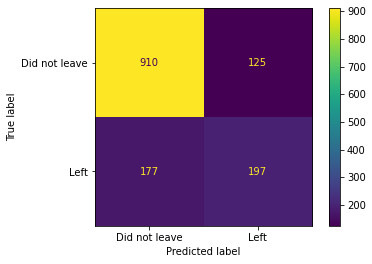

In [139]:
plot_confusion_matrix(model_xgb, #pass in our model
                      X_test, #and our data
                      y_test, #ground truth
                      values_format='d', #make our matrix look pretty
                      display_labels =["Did not leave", "Left"])

### Cross Validation for optimizing

This model is good at classifying people who did not leave (910/1035)! But not as good when classifying people who left (197/374).

Part of the problem is that the data is **imbalanced**.

In this problem statement, we would want to **minimize** people leaving the company. So we should optimize our model to predict people who might leave better than people who did not leave.

XGBoost has a parameter, `scale_pos_weight` which helps with imbalanced data! We can use **Cross Validation** to optimize parameters of our model.

Hyperparameters by XGBoost (to optimize our model):
- `max_depth`
- `learning_rate`
- `reg_lambda` (Regularization)

So let's optimize thiese parameters, in hopes to improve the accuracy with the **Testing Dataset**

Since we have a lot of hyper parameters, we can use GridSearchCV to help us test possible combinations of parameters for us. (but it'll take a longgggggggggg time)

However, we need to know what the hyperparameter means (we can find them on XGBoost documentation)

In [144]:
#defining our hyperparameterswith param_grid
param_grid = {"max_depth" : [3,4,5],
              "learning_rate" : [0.1, 0.01, 1],
              "gamma" : [0.25],
              "reg_lambda":[10, 20, 100],
              "scale_pos_weight" : [3,4,5]}
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic',
                                         subsample=0.9,
                                         colsample_bytree=0.5), param_grid=param_grid,
                                         scoring='roc_auc', n_jobs=10, cv=3)
optimal_params.fit(X_train,y_train)

c:\Users\TAI6SGP\.conda\envs\izEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:31:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_co...
                                     scale_pos_weight=None, subsample=0.9,
                                     tree_method=None, use_label_encoder=True,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=10,
       

From our GridSearchCV, we get the following parameters for our mode.

Note that GridSearchCV is exhaustive, as in, it tests every single combination we put in.

For "scale_pos_weight", 

In [146]:
optimal_params.best_params_

{'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 100,
 'scale_pos_weight': 3}